# Predicting Funding Rate Direction - MODEL1

## Introduction

The objective of **Model 1** is to predict whether the funding rate will **increase** or **decrease** in the next time period. This directional prediction provides the foundational input for **Model 2** (volatility estimation) and **Model 3** (exact value prediction). Accurate direction forecasting is critical for developing robust trading strategies.


### **Objective**

- Predict whether the funding rate will **go up** or **down** in the next period using classification models.


### **Approach**

- **Input Features**:
  - Historical funding rates and their lags.
  - Technical indicators (e.g., moving averages, rate-of-change).
  - Market features (e.g., open interest, mark price).
  - Temporal features (e.g., hour, day).

- **Models Tested**:
  - **Logistic Regression**: A simple baseline for binary classification.
  - **Random Forest Classifier**: Captures non-linear relationships and interactions.
  - **Hyperparameter Tuning**: Applied to optimize model performance.

- **Evaluation Metrics**:
  - **Accuracy**: Correctly predicted directions.
  - **F1 Score**: Handles imbalanced datasets.
  - **ROC AUC**: Measures the model's ability to distinguish classes.

### **Next Steps**

- Use the predicted direction from **Model 1** as an input feature for **Model 2** to forecast funding rate volatility.


In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# absolute path of the project's root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# project root directory to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import data processing functions
from utilities.data_processing import (
    load_data, 
    preprocess_data, 
    create_features, 
    process_pipeline,
    remove_outliers,
    rescale_series
)

# Import feature engineering and data balancing utilities
from utilities.functions import (
    add_lag_features,
    add_technical_indicators,
    add_interaction_terms,
    plot_acf_pacf,
    perform_ljung_box_test
)

# Import model-related utilities
from utilities.model_utils import (
    train_classification_model,
    evaluate_classification_model,
    save_model,
    load_model,
    save_garch_model,
    load_garch_model,
    perform_hyperparameter_tuning,
    plot_feature_importance
)

# Import configurations
from config import (
    BINANCE_BTC_PERP_CSV,
    MODEL1_PATH,
    SCALER1_PATH,
    RANDOM_STATE,
    MODEL2_PATH
)

from sklearn.preprocessing import StandardScaler

## **Step 1: Data Preprocessing and Feature Engineering**

In this step, we prepare the data for modeling by performing preprocessing tasks and creating new features that may improve model performance.

### **1.1 Determining Funding Rate Direction**

We create the target variable `direction` to indicate whether the funding rate is expected to **increase (`1`)** or **decrease/remain the same (`0`)** in the next time period.

- **Methodology**:
  - Shift the `funding_rate` column by one period to get the future funding rate.
  - Compare the future funding rate with the current funding rate to determine the direction.
  - The `direction` is set to `1` if the future funding rate is higher; otherwise, it's `0`.

### **1.2 Feature Engineering**

To enhance the model's predictive power, we generate additional features:

- **Lag Features**:
  - `funding_rate_lag1`: Funding rate from the previous period.
  - `open_interest_lag1`: Open interest from the previous period.
  - `mark_price_lag1`: Mark price from the previous period.

- **Technical Indicators**:
  - `funding_rate_ma3`: 3-period moving average of the funding rate.

- **Cyclical Time Features**:
  - Convert time-based features (hour, day, month) into cyclical features using sine and cosine transformations to capture periodic patterns.

- **Data Handling**:
  - **Missing Values**: Filled `NaN` values resulting from lagging and moving averages using backward fill (`bfill`).
  - **Scaling**: Standardized numerical features to ensure they're on the same scale.

In [ ]:
# Load and preprocess data
df = load_data(BINANCE_BTC_PERP_CSV)
df = preprocess_data(df)
df = create_features(df)

# Create the 'direction' target variable
df['future_funding_rate'] = df['funding_rate'].shift(-1)
df['direction'] = (df['future_funding_rate'] > df['funding_rate']).astype(int)
df.drop(columns=['future_funding_rate'], inplace=True)

# Add lag features
df = add_lag_features(df)

# Add technical indicators
df = add_technical_indicators(df)

# Add interaction features
df = add_interaction_terms(df)

# Handle NaNs appropriately
df.bfill(inplace=True)

## **Step 2: Model Training and Evaluation**

### **2.1 Random Forest Classifier**

#### **Description**

Random Forest is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the mode of the classes as the prediction.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

if not df.empty:
    try:
        print("Starting feature engineering...")

        # Feature Engineering
        df = add_lag_features(df)
        df = add_technical_indicators(df)
        df = add_interaction_terms(df)

        # Define features and target
        feature_columns = [
            'funding_rate_lag1', 'funding_rate_lag2',
            'funding_rate_ma3', 'funding_rate_ma5', 'funding_rate_ema3',
            'open_interest', 'open_interest_lag1', 'open_interest_roc',
            'mark_price', 'mark_price_lag1', 'volatility_5min',
            'funding_rate_roc1', 'funding_rate_roc3', 'interaction2', 'interaction3'
        ]

        X = df[feature_columns]
        y = df['direction']

        print("Splitting the data...")
        split_index = int(0.8 * len(X))
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        if not X_train.empty and not X_test.empty:
            print("Starting preprocessing for Random Forest...")
            start_time = time.time()

            # Explicitly create copies to avoid SettingWithCopyWarning
            X_train_rf = X_train.copy()
            X_test_rf = X_test.copy()

            # Replace infinity values and handle NaNs explicitly for Random Forest
            X_train_rf.replace([np.inf, -np.inf], np.nan, inplace=True)
            X_test_rf.replace([np.inf, -np.inf], np.nan, inplace=True)
            X_train_rf.fillna(0, inplace=True)
            X_test_rf.fillna(0, inplace=True)

            print(f"Preprocessing for Random Forest completed in {time.time() - start_time:.2f} seconds.")
            print(f"Training data shape for Random Forest: {X_train_rf.shape}")
            print(f"Test data shape for Random Forest: {X_test_rf.shape}")

            # Train initial Random Forest model
            print("Training initial Random Forest model...")
            start_time = time.time()
            rf_model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
            rf_model.fit(X_train_rf, y_train)
            print(f"Random Forest training completed in {time.time() - start_time:.2f} seconds.")

            print("\nInitial Model Evaluation:")
            evaluate_classification_model(rf_model, X_test_rf, y_test)

            # Start hyperparameter tuning
            print("Starting hyperparameter tuning...")
            start_time = time.time()
            param_grid = {
                'n_estimators': [50, 100],
                'max_depth': [10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
            best_rf_model = perform_hyperparameter_tuning(
                rf_model,
                param_grid,
                X_train_rf,
                y_train,
                scoring='roc_auc',
                verbose=1
            )
            print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds.")

            print("\nBest Model Evaluation After Hyperparameter Tuning:")
            evaluate_classification_model(best_rf_model, X_test_rf, y_test)

            # Evaluate with a custom threshold
            y_proba = best_rf_model.predict_proba(X_test_rf)[:, 1]
            custom_threshold = 0.5
            print(f"\nEvaluation with Custom Threshold ({custom_threshold}):")
            evaluate_classification_model(best_rf_model, X_test_rf, y_test, y_proba, threshold=custom_threshold)

            # Plot feature importance
            print("Plotting feature importance...")
            plot_feature_importance(best_rf_model, X_train_rf.columns)

            # Save the model and scaler
            print("Saving the model and scaler...")
            save_model(best_rf_model, '../models/saved_models/model1_RF.pkl')

    except Exception as e:
        print(f"Error during Random Forest training and tuning: {e}")

### **2.2 Logistic Regression**

#### **Description**

Logistic Regression is a linear model commonly used for binary classification problems. It models the probability that a given input belongs to a particular category.

In [ ]:
from sklearn.linear_model import LogisticRegression

if not os.path.exists(BINANCE_BTC_PERP_CSV):
    raise FileNotFoundError(f"Dataset not found at {BINANCE_BTC_PERP_CSV}")
else:
    print(f"Dataset found at {BINANCE_BTC_PERP_CSV}")

# Start pipeline execution
print("Starting pipeline execution...")
df = process_pipeline(BINANCE_BTC_PERP_CSV)

if df is None or df.empty:
    print("Dataset not processed properly. Check pipeline.")
    raise ValueError("Processed dataset is empty. Check the pipeline.")

print(f"Shape of DataFrame after processing: {df.shape}")
print(df.head())

# Splitting the data
print("Splitting the data...")
feature_columns = [
    'funding_rate_lag1', 'funding_rate_lag2',
    'funding_rate_ma5', 'funding_rate_ema3',
    'mark_price', 'mark_price_lag1',
    'funding_rate_ma3'
]

missing_columns = [col for col in feature_columns if col not in df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
    raise ValueError(f"The following required columns are missing: {missing_columns}")

X = df[feature_columns]
y = df['direction']

print(f"Feature columns: {feature_columns}")
print(f"Target variable: {y.name}")

split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

# Preprocessing
if not X_train.empty and not X_test.empty:
    print("Starting preprocessing...")
    start_time = time.time()

    # Use preprocess_data from data_processing.py
    X_train = preprocess_data(X_train, handle_timestamps=False)
    X_test = preprocess_data(X_test, handle_timestamps=False)

    numeric_features = [
        'funding_rate_lag1', 'funding_rate_lag2',
        'funding_rate_ma5', 'funding_rate_ema3',
        'mark_price', 'mark_price_lag1',
        'funding_rate_ma3'
    ]

    # Debug preview
    print("Preview of X_train before scaling:")
    print(X_train[numeric_features].head())

    # Scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[numeric_features])
    X_test_scaled = scaler.transform(X_test[numeric_features])

    # Prepare processed data
    X_train_prepared = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train.index)
    X_test_prepared = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test.index)

    print(f"Preprocessing completed in {time.time() - start_time:.2f} seconds.")
    print(f"Training data shape after preprocessing: {X_train_prepared.shape}")
    print(f"Test data shape after preprocessing: {X_test_prepared.shape}")

    # Train Logistic Regression model
    print("Training Logistic Regression model...")
    start_time = time.time()
    logreg_model = LogisticRegression(
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    )
    logreg_model.fit(X_train_prepared, y_train)
    print(f"Logistic Regression training completed in {time.time() - start_time:.2f} seconds.")

    # Evaluate initial model
    print("\nInitial Logistic Regression Model Evaluation:")
    evaluate_classification_model(logreg_model, X_test_prepared, y_test)

    # Hyperparameter tuning
    print("Starting hyperparameter tuning...")
    start_time = time.time()
    param_grid_logreg = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    best_logreg_model = perform_hyperparameter_tuning(
        LogisticRegression(
            random_state=42,
            class_weight='balanced',
            max_iter=1000
        ),
        param_grid_logreg,
        X_train_prepared,
        y_train,
        scoring='f1'
    )
    print(f"Hyperparameter tuning completed in {time.time() - start_time:.2f} seconds.")

    # Evaluate best model
    print("\nBest Logistic Regression Model Evaluation After Hyperparameter Tuning:")
    evaluate_classification_model(best_logreg_model, X_test_prepared, y_test)

    # Adjust classification threshold
    y_proba_logreg = best_logreg_model.predict_proba(X_test_prepared)[:, 1]
    custom_threshold = 0.4
    print(f"\nEvaluation with Custom Threshold ({custom_threshold}):")
    evaluate_classification_model(best_logreg_model, X_test_prepared, y_test, y_proba_logreg, threshold=custom_threshold)

    # Plot feature importance
    print("Plotting feature importance...")
    plot_feature_importance(best_logreg_model, X_train_prepared.columns, model_type='logistic_regression')

    # Save the Logistic Regression model
    print("Saving the Logistic Regression model...")
    save_model(best_logreg_model, '../models/saved_models/model1_LR.pkl')
    save_model(scaler, '../models/saved_models/scaler1_LR.pkl')

else:
    print("Training or test datasets are empty. Cannot proceed.")


### **2.3 Model Comparison**

- Compared the performance of logistic regression and Random Forest models.
- Discussed which model performed better and why.
- Considered factors like overfitting, computational efficiency, and interpretability.

#### Random Forest Classifier

- **Initial Accuracy**: 75.79%
- **After Tuning Accuracy**: 78.75% (+3%)
- **F1 Score After Tuning**: 71.27% (+20%)
- **Strength**: Captures non-linear interactions effectively.

#### Logistic Regression

- **Accuracy**: 80.26% (unchanged post-tuning)
- **F1 Score**: 65.89%
- **Limitation**: Struggles with non-linear relationships.

#### Best Model: Random Forest Classifier

- **Reason**: Higher recall and F1 Score for imbalanced data, making it better suited for this dataset.

#### Improvement Suggestions

1. Add polynomial features or interactions for better representation of the data.
2. Use **SMOTE** to handle the imbalanced dataset effectively.
3. Experiment with ensemble models like stacking or boosting for improved performance.
4. Test **Elastic Net** regularization to optimize Logistic Regression.
5. Apply stratified K-fold cross-validation to evaluate model robustness.

TRY XGBOOST AND LSTM


# **Predicting Funding Rate Volatility - MODEL2**

## Introduction

Building on **Model 1** (Random Forest Classifier), which predicted the funding rate's direction, **Model 2** focuses on forecasting **volatility** to quantify the magnitude of market fluctuations. Accurate volatility predictions are critical for assessing risk and market movement intensity.


### **Objective**

- Predict the **volatility** (variance) of funding rates to evaluate the extent of potential market fluctuations.


### **Segway from Model 1**

- **Input**: Direction predictions (up/down) from **Model 1** serve as a guiding feature to contextualize volatility estimation.


### **Approach**

- Implement and compare **GARCH-based models**:
  - **GARCH (1,1)**: Captures volatility clustering.
  - **EGARCH**: Models asymmetric shocks.
  - **GJR-GARCH**: Accounts for leverage effects.
- Evaluate models using statistical metrics like **AIC** and **BIC**.


### **Next Steps**

- Forecast volatility using the best GARCH model.
- Save and integrate the output with **Model 3** to predict exact funding rate values.


Loading the dataset...
Data loaded. Preview:
          exchange   symbol  local_timestamp  funding_timestamp  funding_rate  \
0  binance-futures  BTCUSDT     1.577840e+15       1.577866e+15     -0.000161   
1  binance-futures  BTCUSDT     1.577844e+15       1.577866e+15     -0.000173   
2  binance-futures  BTCUSDT     1.577848e+15       1.577866e+15     -0.000183   
3  binance-futures  BTCUSDT     1.577851e+15       1.577866e+15     -0.000191   
4  binance-futures  BTCUSDT     1.577855e+15       1.577866e+15     -0.000187   

   predicted_funding_rate  open_interest  last_price  index_price  \
0                     NaN            NaN     7171.55          NaN   
1                     NaN            NaN     7208.32          NaN   
2                     NaN            NaN     7237.49          NaN   
3                     NaN            NaN     7221.55          NaN   
4                     NaN            NaN     7214.00          NaN   

    mark_price         timestamp  
0  7176.918847  15

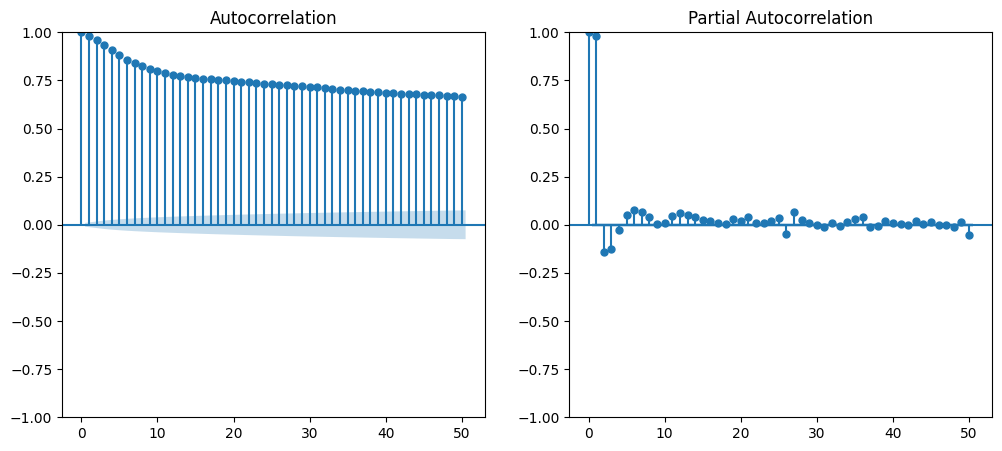


Fitting GARCH Models...

Fitting GARCH(1,1) with Normal Distribution...

                       Zero Mean - GARCH Model Results                        
Dep. Variable:           funding_rate   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                298769.
Distribution:                  Normal   AIC:                          -597532.
Method:            Maximum Likelihood   BIC:                          -597506.
                                        No. Observations:                38986
Date:                Sun, Dec 01 2024   Df Residuals:                    38986
Time:                        10:05:19   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-------------------------------------------------------------

c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                          Zero Mean - GARCH Model Results                           
Dep. Variable:                 funding_rate   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                298430.
Distribution:      Standardized Student's t   AIC:                          -596852.
Method:                  Maximum Likelihood   BIC:                          -596818.
                                              No. Observations:                38986
Date:                      Sun, Dec 01 2024   Df Residuals:                    38986
Time:                              10:05:19   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\viraj\BuildSpace\Projects\stat429_project\venv\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                       Zero Mean - EGARCH Model Results                       
Dep. Variable:           funding_rate   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:           -1.12268e+08
Distribution:                  Normal   AIC:                       2.24535e+08
Method:            Maximum Likelihood   BIC:                       2.24535e+08
                                        No. Observations:                38986
Date:                Sun, Dec 01 2024   Df Residuals:                    38986
Time:                        10:05:19   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         -7.2440     14.609     -0.496      0.620    [-3

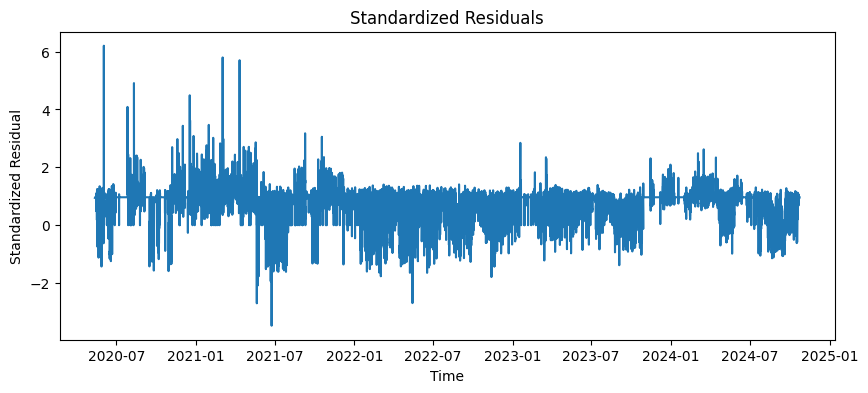

Plotting Conditional Volatility...


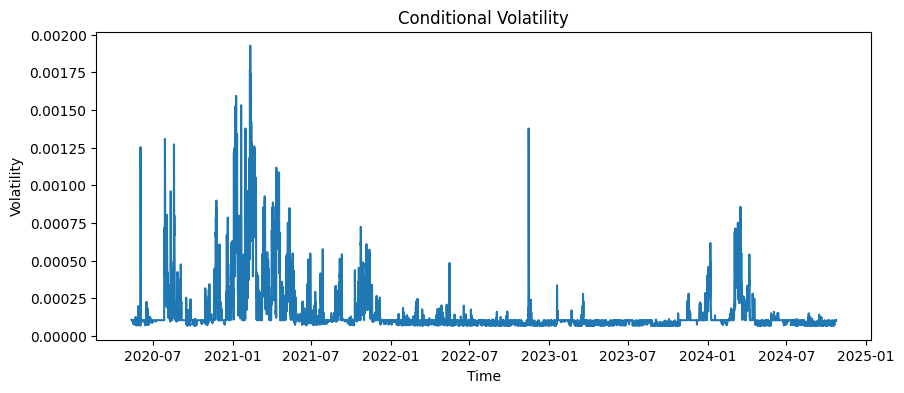


Forecasting Future Volatility...

Forecasted Conditional Variances:
h.1    1.071490e-08
h.2    1.192957e-08
h.3    1.311994e-08
h.4    1.428651e-08
h.5    1.542974e-08
Name: 2024-10-23 10:00:00+00:00, dtype: float64

Plotting Forecasted Volatility...


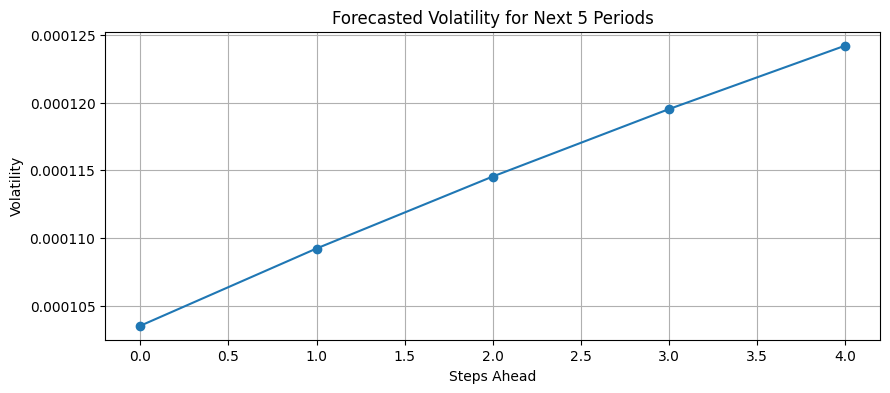


Saving the Best GARCH Model...

GARCH model saved to c:\Users\viraj\BuildSpace\Projects\stat429_project\models\saved_models\model2_garch.pkl


In [2]:
import warnings
warnings.filterwarnings('ignore')
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

# Process the data using the pipeline with rescaling
df = process_pipeline(
    BINANCE_BTC_PERP_CSV,
    rescale=True,            
    scaling_factor=1e6,       
    handle_outliers=False     
)

# ===========================================
# Data Preprocessing and Feature Engineering
# ===========================================

# Process the data using the pipeline
df = process_pipeline(BINANCE_BTC_PERP_CSV)

# Ensure 'timestamp' is set as index for time series analysis
df.set_index('timestamp', inplace=True)

# Extract the funding rate series
funding_rate_series = df['funding_rate']

# Handle missing values in 'funding_rate'
funding_rate_series = funding_rate_series.dropna()

# ===========================================
# Stationarity Check
# ===========================================

print("\nPerforming Augmented Dickey-Fuller (ADF) Test for Stationarity...\n")

adf_result = adfuller(funding_rate_series)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

if adf_result[1] > 0.05:
    print("The series is non-stationary. Differencing is required.")
    # First difference
    funding_rate_series = funding_rate_series.diff().dropna()
    print("Performed first differencing to achieve stationarity.")
else:
    print("The series is stationary.")
    
# ===========================================
# Plot ACF and PACF
# ===========================================

print("\nPlotting ACF and PACF...\n")
plot_acf_pacf(funding_rate_series, lags=50)

# ===========================================
# Fit GARCH Models
# ===========================================

print("\nFitting GARCH Models...\n")

# 6.1. GARCH(1,1) with Normal Distribution
print("Fitting GARCH(1,1) with Normal Distribution...\n")
garch11 = arch_model(
    funding_rate_series,
    vol='GARCH',
    p=1,
    q=1,
    mean='Zero',
    dist='normal'
)
garch11_result = garch11.fit(update_freq=5, disp='off')
print(garch11_result.summary())

# 6.2. GARCH(1,1) with Student's t-Distribution
print("\nFitting GARCH(1,1) with Student's t-Distribution...\n")
garch11_t = arch_model(
    funding_rate_series,
    vol='GARCH',
    p=1,
    q=1,
    mean='Zero',
    dist='t'
)
garch11_t_result = garch11_t.fit(update_freq=5, disp='off')
print(garch11_t_result.summary())

# 6.3. EGARCH(1,1) with Normal Distribution
print("\nFitting EGARCH(1,1) with Normal Distribution...\n")
egarch11 = arch_model(
    funding_rate_series,
    vol='EGARCH',
    p=1,
    q=1,
    mean='Zero',
    dist='normal'
)
egarch11_result = egarch11.fit(update_freq=5, disp='off')
print(egarch11_result.summary())

# 6.4. GJR-GARCH(1,1) with Normal Distribution
print("\nFitting GJR-GARCH(1,1) with Normal Distribution...\n")
gjr_garch11 = arch_model(
    funding_rate_series,
    vol='GARCH',
    p=1,
    o=1,
    q=1,
    mean='Zero',
    dist='normal'
)
gjr_garch11_result = gjr_garch11.fit(update_freq=5, disp='off')
print(gjr_garch11_result.summary())

# ===========================================
# Model Selection and Evaluation
# ===========================================

print("\nComparing Models Using AIC and BIC...\n")

models = {
    'GARCH(1,1) Normal': garch11_result,
    'GARCH(1,1) t': garch11_t_result,
    'EGARCH(1,1) Normal': egarch11_result,
    'GJR-GARCH(1,1) Normal': gjr_garch11_result
}

for name, result in models.items():
    print(f"{name} - AIC: {result.aic:.3f}, BIC: {result.bic:.3f}")

# Select the best model based on AIC
best_model_name = min(models, key=lambda k: models[k].aic)
best_model_result = models[best_model_name]
print(f"\nSelected Model Based on Lowest AIC: {best_model_name}\n")

# ===========================================
# Residual Analysis
# ===========================================

print("Analyzing Residuals...\n")

# Get standardized residuals
residuals = best_model_result.std_resid

# Perform Ljung-Box test on residuals
print("Performing Ljung-Box Test on Residuals:")
perform_ljung_box_test(residuals, lags=10)

# Perform Ljung-Box test on squared residuals
print("\nPerforming Ljung-Box Test on Squared Residuals:")
perform_ljung_box_test(residuals**2, lags=10)

# Plot standardized residuals
print("\nPlotting Standardized Residuals...")
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Standardized Residuals')
plt.xlabel('Time')
plt.ylabel('Standardized Residual')
plt.show()

# Plot conditional volatility
print("Plotting Conditional Volatility...")
plt.figure(figsize=(10, 4))
plt.plot(best_model_result.conditional_volatility)
plt.title('Conditional Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.show()

# ===========================================
# Forecasting
# ===========================================

print("\nForecasting Future Volatility...\n")

# Forecast volatility for the next 5 periods
forecast_horizon = 5
volatility_forecast = best_model_result.forecast(horizon=forecast_horizon)

# Extract forecasted conditional variances
forecasted_variances = volatility_forecast.variance.iloc[-1]

print("Forecasted Conditional Variances:")
print(forecasted_variances)

# Plot forecasted volatility
print("\nPlotting Forecasted Volatility...")
plt.figure(figsize=(10, 4))
plt.plot(np.sqrt(forecasted_variances.values), marker='o')
plt.title(f'Forecasted Volatility for Next {forecast_horizon} Periods')
plt.xlabel('Steps Ahead')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

# ===========================================
# Saving the Model
# ===========================================

print("\nSaving the Best GARCH Model...\n")

# Save the best GARCH model
save_garch_model(best_model_result, MODEL2_PATH)
print(f"GARCH model saved to {MODEL2_PATH}")




